In [2]:
import numpy as np
import pandas as pd
import re
import itertools
from collections import Counter
import pickle
import jieba
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
%matplotlib inline

# Read the Dataset

In [3]:
data = pd.read_csv('./online_shopping_10_cats.csv')
data = data[['cat', 'review']] # only keep the review text
data.sample(10) # get a sample to take a look at the data

,cat,review
3841,书籍,《不一样的卡梅拉》的确不一样！家里那么多图书，儿子偏偏对它情有独钟。没事就把它从书架上拿下来...
44243,衣服,裤子还凑活有点太古板
9015,平板,差评，京东玩文字游戏，在线咨询有赠品，购买后，就随机5选1，差评，差评，差评
18367,水果,有点小，吃着脆甜，包装很好，孩子喜欢吃，物流比较快，服务态度也不错。
36857,蒙牛,蒙牛不错
58764,酒店,很晚到的酒店 酒店一般般
299,书籍,"这本书是我读林达的书的第一本,正是这本书吸引我买了一套他的书.作为一位在西方生活了很长时间的..."
27264,洗发水,很划算，小支的方便携带。有两大瓶洗发水和一瓶护发素，很实用哟！每次洗头得两次，再也不会担心洗...
34616,洗发水,都洒在盒子里里，京东现在怎么也变成这样了啊……
60443,酒店,酒店位置和服务都不错。所以已经第二次入住北京昆仑饭店。虽然携程预订页面说目前北京全城禁烟，酒...


# Data Preprocess

In [59]:
# Select 1000 items for quick calculation, I selected 100 reviews from each category to make a balanced dataset
select_data = data.groupby('cat', group_keys=False).apply(pd.DataFrame.sample, 100)

In [15]:
def clean_data(text):
    cleaned_text = re.sub(r"[\s\/\\_$^*(+\"\'+~\-@#&^*\[\]{}【】]+", "", str(text))
    return cleaned_text

In [61]:
select_data['cleaned_text'] = select_data.review.apply(clean_data)

In [62]:
text_length = select_data.cleaned_text.apply(len)

In [63]:
text_length.describe()

count    1000.00000
mean       63.21700
std        89.24534
min         2.00000
25%        20.00000
50%        35.00000
75%        70.00000
max       969.00000
Name: cleaned_text, dtype: float64

In [64]:
select_data.loc[text_length == text_length.min()]

,cat,review,cleaned_text
36185,热水器,可以,可以


In [65]:
select_data['words'] = select_data.cleaned_text.apply(jieba.lcut)

# Features

## Bag of words

In [66]:
# Build a dictionary
word_counter = Counter([x for y in select_data.words.tolist() for x in y])
id_word_dict = {idx: item[0] for idx, item in enumerate(word_counter.most_common())}
word_id_dict = {word: idx for idx, word in id_word_dict.items()}

In [67]:
# Convert word list to id list
def word_to_id(word_list):
    return [word_id_dict[w] for w in word_list]

select_data['word_id'] = select_data.words.apply(word_to_id)

In [68]:
# Create a matrix for the feature
bow_encoding = np.zeros([len(select_data), len(id_word_dict)])
bow_encoding.shape

(1000, 7350)

In [69]:
# Count the words and add to feature
for idx, words in enumerate(select_data.word_id.tolist()):
    for w in words:
        bow_encoding[idx][w] += 1

## TF-IDF

In [52]:
from sklearn.feature_extraction.text import TfidfVectorizer

corpus = [' '.join(item) for item in select_data.words.tolist()]

tfidf = TfidfVectorizer()
tfidf_encoding = tfidf.fit_transform(corpus)

In [53]:
tfidf_encoding.shape

(1000, 6430)

## Bert Encoding

In [79]:
from bert_serving.client import BertClient
bc = BertClient()

In [80]:
bert_encoding = bc.encode(select_data.review.tolist())

some of your sentences have more tokens than "max_seq_len=25" set on the server, as consequence you may get less-accurate or truncated embeddings.
here is what you can do:
- disable the length-check by create a new "BertClient(check_length=False)" when you just want to ignore this warning
- or, start a new server with a larger "max_seq_len"


# Clustering with K-Means

In [77]:
# Start clustering
from sklearn.cluster import KMeans
N_clusters = 50 # Just set a number of clusters
bow_pred = KMeans(n_clusters=N_clusters, random_state=0).fit_predict(bow_encoding)

(array([ 66.,   1.,  10., 208.,  19.,   1.,   1.,   1.,   1.,   1.,   1.,
          3.,   1.,   1.,   1.,  29.,  83.,   1.,   2.,   1.,  29.,   1.,
          1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,  15.,   1.,
          1.,   1.,   1.,   1.,   1.,   1., 320., 100.,   1.,  25.,   7.,
          1.,  43.,   1.,   1.,   8.]),
 array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
        13., 14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25.,
        26., 27., 28., 29., 30., 31., 32., 33., 34., 35., 36., 37., 38.,
        39., 40., 41., 42., 43., 44., 45., 46., 47., 48., 49.]),
 <a list of 49 Patch objects>)

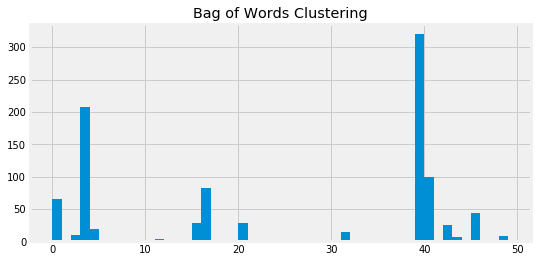

In [78]:
plt.figure(figsize=[8, 4])
plt.title('Bag of Words Clustering')
plt.hist(bow_pred, bins=np.linspace(0, N_clusters-1, num=N_clusters))

The distribution is very uneven as shown above. Ideally all the reviews should be equally divided into 10 clusters but obviously this cannot happen in reality. 

In [99]:
select_data.iloc[list(np.where(bow_pred==48)[0])][['review']]

,review
14764,1、桔黄色灯光炫目2、四合弦铃声动听3、七十克机身轻巧4、一星期待机舒服5、200条电话记录...
15692,1、电话本查找相当不方便（包括查找一个联系人和找到该联系人后查询其名下的各个电话号码）；2、...
31333,洗了好多头皮屑哦、、、、、、
27458,物有所值、每次都去超市买、正好京东打折、而且送的小样、可以出差带着、特别方便、还送一个发膜、...
26950,不错、不错、值得购买哦、洗了一下头发很舒服、一直用沙宣、值得信赖
37395,我的吃货细胞就要爆发了。眼馋各种好吃的：锅巴、土豆片、牛板筋、蒙牛大果粒、饮料、鸭肠、鸭脖、...
50154,1、屏幕分辨率高，独显，适合做图 2、速度够快 3、没什么问题，使用非常正常， 4、3DMa...


In [54]:
N_clusters = 30
tfidf_pred = KMeans(n_clusters=N_clusters, random_state=0).fit_predict(tfidf_encoding)

(array([ 7., 43., 38., 17., 55., 56., 38., 47., 41., 56., 31., 16., 29.,
        25., 29., 21., 61., 30., 34., 34., 36., 41., 30., 35., 45., 41.,
        11., 10., 43.]),
 array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
        13., 14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25.,
        26., 27., 28., 29.]),
 <a list of 29 Patch objects>)

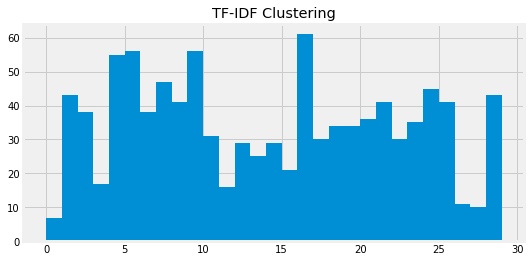

In [56]:
plt.figure(figsize=[8, 4])
plt.title('TF-IDF Clustering')
plt.hist(tfidf_pred, bins=np.linspace(0, N_clusters-1, num=N_clusters))

The histogram looks more balanced than the previous bag of words one.

In [58]:
select_data.iloc[list(np.where(tfidf_pred==0)[0])][['review']]

,review
13429,不爽，没赠品。。。。。。。。。
10583,什么赠品都没赠送，东西还比正常的要重，感觉是假的，没办法这价位也就这样了，劝大家别差那点钱，...
15092,电池太差了！偶尔还死死机．不知其他夏新是不也这样，不爽
36369,还没拆开，但是包装的很好。第二次来买了，还送了赠品，nice。谢谢
36670,一次很不爽的购物，页面上说是第二天能到货，结果货是从陕西发出的，卖家完全知道第二天根本到不了...
36412,正品，赠品也不错
51828,相比此时一起促销的宏基感觉亏大了。价格降幅，赠品什么都比不上。


It seems obviously in this cluster every review has the words '赠品'(gift)

In [81]:
N_clusters = 30
bert_pred = KMeans(n_clusters=N_clusters, random_state=0).fit_predict(bert_encoding)

(array([ 15.,  12.,  38.,  44.,  28.,  27.,  32.,  53.,  43.,  23.,  42.,
         20.,  57.,  26.,  34.,  35.,  23.,  31.,  30.,  58.,  29.,  27.,
          4.,  36.,  51.,  25.,  19.,  38., 100.]),
 array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
        13., 14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25.,
        26., 27., 28., 29.]),
 <a list of 29 Patch objects>)

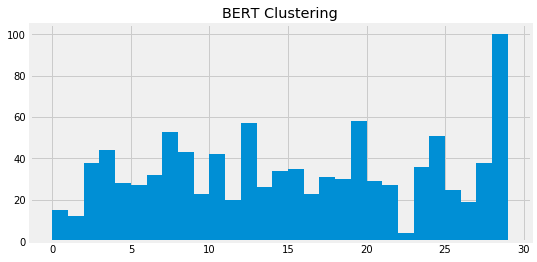

In [82]:
plt.figure(figsize=[8, 4])
plt.title('BERT Clustering')
plt.hist(bert_pred, bins=np.linspace(0, N_clusters-1, num=N_clusters))

In [84]:
select_data.iloc[list(np.where(bert_pred==0)[0])][['review']]

,review
5635,还不错，孩子用
4683,很好，很喜欢，价格也不贵
7926,是的。还不错。挺好的
3940,还可以，性价比高
7522,满意！屏够大！电量够足
7963,非常不错的产品
36414,东西很好。
36213,还是不错的.
36337,很好的商品，家庭必备
36314,物美价廉，值得拥有


In [86]:
select_data.iloc[list(np.where(bert_pred==2)[0])][['review']]

,review
5498,华为平板M3最新版本emui5.0华为平板m3青春版都是emui5.1。有点看不懂了，旗舰平...
6015,画面细腻，音效好，使用流畅，物流给力
14764,1、桔黄色灯光炫目2、四合弦铃声动听3、七十克机身轻巧4、一星期待机舒服5、200条电话记录...
15870,1.显示效果一般。2.只支持无声视频拍摄。3.软体兼容性和运行速度不能令人满意。4.没有提供...
14279,"1.音质绝佳。左右各有一个立体声扬声器。2.在""诺基亚6270""上，NOKIA第一次使用QV..."
14752,待机时间比较长！铃声虽为单声，但和我以前那个单声小灵通相比，还是比较满意。电话薄比较大，可以...
14616,64和弦，1.8寸26万色TFT，1.3寸LCD，WAP1.2.1，红外，联想输入法，
14288,"这款手机优点很多1、外形很漂亮,我的是一款红色的,满可爱的 2、耐用.不小心摔过两次,一点儿..."
14708,1.屏幕画质比较细腻清晰，色彩艳丽。2.待机时间比较理想，一般不会下来四天时间。3.可以通过...
14066,"W800c是一款集通讯，MP3播放和数码相机等功能与一身的索爱强力机型。1.白色的机身,机身..."
